In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import os
# os.chdir(r'/content/drive/My Drive/ECE1512_TA')  # Change the directory to torchRay-master folder

# Requirements

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

# Dataset loader

In [5]:
train_dir = './hmt_dataset/HMT_train' #you should change to your directory
test_dir = './hmt_dataset/HMT_test' #you should change to your directory

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [6]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten?

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
#model.add(Dense(1024, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
#                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                    

# Training

In [9]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.SGD(),
              metrics=['accuracy'])

In [10]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log2', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [11]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    epochs=150,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)

C:\Users\Jiaming\AppData\Local\Temp\ipykernel_15328\8318593.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,


Epoch 1/150
140/140 [==============================] - 301s 2s/step - loss: 1.9659 - accuracy: 0.2319
Epoch 2/150
  6/140 [>.............................] - ETA: 5:11 - loss: 1.6852 - accuracy: 0.3333

KeyboardInterrupt: 

In [13]:
model.save('HMT.h5')

# Load Model

In [14]:
model=load_model('HMT.h5')

In [16]:
def my_summary_iterator(path):
  for r in tf_record.tf_record_iterator(path):
    yield event_pb2.Event.FromString(r)
train_acc = []
train_loss = []
train_lr = []
#print('log/train/' + os.listdir('log/train')[2])
for e in my_summary_iterator('./log2/train/' + os.listdir('./log2/train')[-1]):
  for v in e.summary.value:
    if v.tag == 'epoch_accuracy':
      train_acc.append(v.simple_value)
    elif v.tag == 'epoch_loss':
      train_loss.append(v.simple_value)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Text(0.5, 1.0, 'Training progress: Accuracy')

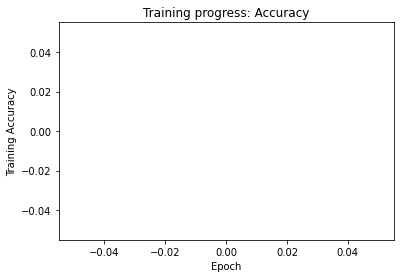

In [17]:
plt.plot(np.arange(len(train_acc)), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training progress: Accuracy')

In [ ]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training progress: Loss')

# Explanation

Load the explaier library

In [18]:
from xai_utils import *

Load a batch of images

In [19]:
test_generator.reset()

In [20]:
image_batch,label_batch=test_generator.next()

Classes:

In [21]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

Predict a single image

In [22]:
index=8

In [23]:
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

True label: Tumor
Predicted_label: Lympho
Confidence score for the correct label: 0.18874691


Generate explanation map

## SISE (Semantic Input Sampling for Explanation)

Set the layer(s)

In [26]:
layers=[['conv2d_3']]

In [27]:
%%time
explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
explanation_map_SISE -= explanation_map_SISE.min()
explanation_map_SISE /= explanation_map_SISE.max()+10e-30

CPU times: total: 4.69 s
Wall time: 884 ms


## Grad-CAM (Gradient-based Class Activation Mapping)

In [28]:
%%time
explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
explanation_map_GradCAM -= explanation_map_GradCAM.min()
explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

CPU times: total: 297 ms
Wall time: 197 ms


## Grad-CAM++

In [29]:
%%time
explanation_map_GradCAMPP = grad_cam_plus_plus(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
explanation_map_GradCAMPP -= explanation_map_GradCAMPP.min()
explanation_map_GradCAMPP /= explanation_map_GradCAMPP.max()+10e-30

CPU times: total: 984 ms
Wall time: 365 ms


## RISE (Randomized Input Sampling for Explanation)

In [30]:
%%time
explanation_map_RISE = RISE(image_batch[index], model, class_index=np.argmax(prediction[index]) ,N_MASKS=1000)
explanation_map_RISE -= explanation_map_RISE.min()
explanation_map_RISE /= explanation_map_RISE.max()+10e-30

CPU times: total: 1min 29s
Wall time: 14.3 s


## Plot the results

Text(0.5, 1.0, 'Explanation map (RISE)')

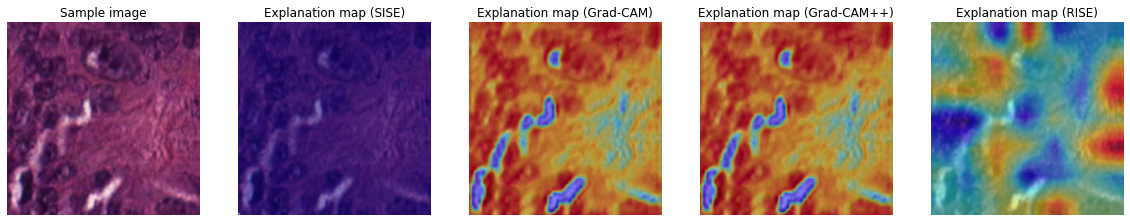

In [31]:
#@title Plot the results

plt.figure(figsize=(20,5))

plt.subplot(1,5,1)
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Sample image')

plt.subplot(1,5,2)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_SISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (SISE)')

plt.subplot(1,5,3)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM)')

plt.subplot(1,5,4)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_GradCAMPP, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM++)')

plt.subplot(1,5,5)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_RISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (RISE)')

## Quantitative evaluation of the explanation algorithm

In [32]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [ ]:
val_generator.reset()
drop_rate = 0.
for _ in range(15):
    image_batch,label_batch=val_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
        drop_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_SISE, class_index=np.argmax(prediction[index]), frac=0.9)[0]
drop_rate /= (15*32)